In [1]:
import os
from ftplib import FTP
import pandas as pd
import datetime as dt

def download_spires_data(
    year: int,
    months: list[str],
    product: str = "NRT",         # or "HIST"
    tile: str = "h09v05",
    destination_base: str = "~/data/spires"
):
    """
    Download SPIRES data from the CU FTP server for a given year and list of months.
    
    Parameters:
        year (int): The year of data to download (e.g., 2023)
        months (list[str]): List of 2-digit month strings to download (e.g., ["04", "05"])
        product (str): Either "NRT" or "HIST"
        tile (str): Tile identifier, e.g., "h09v05"
        destination_base (str): Base path to store data (e.g., "~/data/spires")
    """
    
    # Validate input
    assert product in ["NRT", "HIST"], "Product must be 'NRT' or 'HIST'"
    for m in months:
        assert len(m) == 2 and m.isdigit(), f"Month {m} must be a 2-digit string"

    # FTP connection info
    host_name = "dtn.rc.colorado.edu"
    ftp_user = "anonymous"
    ftp_pwd = "pwd"
    base_path = "/shares/snow-today/spires"
    sub_path = f"SPIRES_{product}_V01/{tile}"
    remote_path = f"{base_path}/{sub_path}/{year}"

    # Create date range and filter
    start_date = dt.datetime(year, 1, 1)
    end_date = dt.datetime(year, 12, 31)
    all_dates = pd.date_range(start=start_date, end=end_date, freq="D")
    filtered_dates = all_dates[all_dates.strftime("%m").isin(months)]

    # Format filenames
    file_template = f"SPIRES_{product}_h09v05_MOD09GA061_{{date}}_V1.0.nc"
    file_names = [file_template.format(date=d.strftime("%Y%m%d")) for d in filtered_dates]

    # Create local output directory
    output_dir = os.path.expanduser(f"{destination_base}/{year}")
    os.makedirs(output_dir, exist_ok=True)

    # Connect to FTP and download files
    ftp = FTP(host_name)
    ftp.login(user=ftp_user, passwd=ftp_pwd)
    ftp.cwd(remote_path)

    for fname in file_names:
        local_path = os.path.join(output_dir, fname)
        if not os.path.exists(local_path):  # Avoid redownloading
            try:
                with open(local_path, 'wb') as f:
                    ftp.retrbinary(f"RETR {fname}", f.write)
                print(f"Downloaded: {fname}")
            except Exception as e:
                print(f"❌ Could not download {fname}: {e}")
        else:
            print(f"✔️ Already exists: {fname}")

    ftp.quit()
    print(f"All downloads complete. Check {output_dir} for files.")
    return

In [10]:
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
test_download_spires_data = download_spires_data(
    year=2025,
    months=["04", "05"],
    product="NRT",
    tile="h09v05",
    destination_base="~/data/spires")

✔️ Already exists: SPIRES_NRT_h09v05_MOD09GA061_20250401_V1.0.nc
✔️ Already exists: SPIRES_NRT_h09v05_MOD09GA061_20250402_V1.0.nc
✔️ Already exists: SPIRES_NRT_h09v05_MOD09GA061_20250403_V1.0.nc
✔️ Already exists: SPIRES_NRT_h09v05_MOD09GA061_20250404_V1.0.nc
✔️ Already exists: SPIRES_NRT_h09v05_MOD09GA061_20250405_V1.0.nc
✔️ Already exists: SPIRES_NRT_h09v05_MOD09GA061_20250406_V1.0.nc
✔️ Already exists: SPIRES_NRT_h09v05_MOD09GA061_20250407_V1.0.nc
✔️ Already exists: SPIRES_NRT_h09v05_MOD09GA061_20250408_V1.0.nc
✔️ Already exists: SPIRES_NRT_h09v05_MOD09GA061_20250409_V1.0.nc
✔️ Already exists: SPIRES_NRT_h09v05_MOD09GA061_20250410_V1.0.nc
✔️ Already exists: SPIRES_NRT_h09v05_MOD09GA061_20250411_V1.0.nc
✔️ Already exists: SPIRES_NRT_h09v05_MOD09GA061_20250412_V1.0.nc
✔️ Already exists: SPIRES_NRT_h09v05_MOD09GA061_20250413_V1.0.nc
✔️ Already exists: SPIRES_NRT_h09v05_MOD09GA061_20250414_V1.0.nc
✔️ Already exists: SPIRES_NRT_h09v05_MOD09GA061_20250415_V1.0.nc
✔️ Already exists: SPIRES

In [ ]:
# open the basin of interest
basin_file = ("~/data/CONFLUENCE_data/domain_East_River/shapefiles/catchment/East_River_HRUs_GRUs.shp")
basin_gdf = gpd.read_file(basin_file)

# lets check one of these files
test_file = os.path.join(os.path.expanduser("~/data/spires/2025"), "SPIRES_NRT_h09v05_MOD09GA061_20250401_V1.nc")
ds = xr.open_dataset(test_file)

# write crs
ds = ds.rio.write_crs(ds.crs.attrs['crs_wkt'])

# check to make sure the crs matches between basin_gdf and ds 
if basin_gdf.crs != ds.rio.crs:
    print("CRS mismatch! Basin GDF CRS:", basin_gdf.crs, "Dataset CRS:", ds.rio.crs)
    # reproject ds to match basin_gdf
    ds = ds.rio.reproject(basin_gdf.crs)
    print("Reprojected dataset CRS:", ds.rio.crs)
    # check that they match again
    if basin_gdf.crs != ds.rio.crs:
        raise ValueError("CRS still does not match after reprojection!")


CRS mismatch! Basin GDF CRS: EPSG:4326 Dataset CRS: PROJCS["MODIS Sinusoidal",GEOGCS["User with datum World Geodetic Survey 1984",DATUM["unnamed",SPHEROID["unnamed",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Reprojected dataset CRS: EPSG:4326


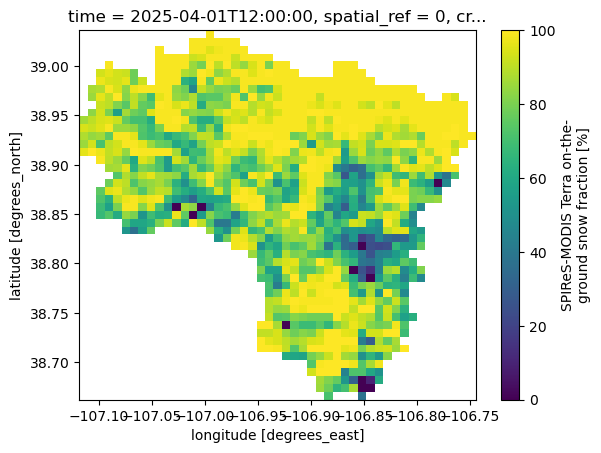

In [16]:
# now we can clip the dataset to the basin
ds_clipped = ds.rio.clip(basin_gdf.geometry, basin_gdf.crs, drop=True)

# let's plot the snow_fraction variable
ds_clipped['snow_fraction'].plot(cmap='viridis')

Next, I want to download the dem and reproject to match. then we can create a time series as different elevation bands. we could also try adding in the NLCD dataset to see if filtering on that makes a difference. 